## Подключитесь к базе. Загрузите таблицы sql

Заказ: для каршеринговой компании нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. 

Дано: база данных SQL с данными по ДТП, их участникам и задействованным в них ТС.

Шаг первый: импорт всех библиотек и загрузка данных из SQL в pandas DataFrame

In [37]:
!pip install ydata-profiling


In [38]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [39]:
pip install --upgrade Pillow

Note: you may need to restart the kernel to use updated packages.


In [40]:
import pandas as pd
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
from sqlalchemy import create_engine 
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import  StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from catboost import CatBoostClassifier, Pool
import plotly.express as px

In [41]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 

In [42]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [43]:
engine = create_engine(connection_string) 

In [44]:
# создадим константы для таблиц из БД, чтобы не прописывать каждый раз длинный путь к ним

vehicles = 'db.vehicles'
collisions = 'db.collisions'
parties = 'db.parties'

## Проведите первичное исследование таблиц

Проверим все таблицы из БД и их соответствие условиям задачи.

In [45]:
query = '''
SELECT *
FROM parties
LIMIT 30;
'''

parties_df = pd.read_sql_query(query, con=engine) 

In [46]:
parties_df

id  case_id  party_number   party_type  at_fault  insurance_premium  \
0    22  3899454             1   road signs         1               29.0   
1    23  3899454             2   road signs         0                7.0   
2    29  3899462             2          car         0               21.0   
3    31  3899465             2   road signs         0               24.0   
4    41  3899478             2  road bumper         0                NaN   
5    43  3899481             2  road bumper         0                NaN   
6    72  3899505             2  road bumper         0                NaN   
7    73  3899505             3  road bumper         0                NaN   
8    76  3899509             1  road bumper         0                NaN   
9    93  3981292             2  road bumper         0                NaN   
10  111  3982068             2  road bumper         0                NaN   
11  126  3982887             1         None         1                NaN   
12  115  3982076             2  road bumper         0                NaN   
13  135  3982892             2  road bumper         0                NaN   
14  142  3982898             2          car         0               71.0   
15  163  3982910             1     building         1               15.0   
16  170  3982914             1     building         1               21.0   
17  171  3982914             2          car         0               43.0   
18  176  3982918             1     building         1               59.0   
19  222  3982945             1     building         1               47.0   
20  224  3982946             2     building         0               62.0   
21  216  3982941             3  road bumper         0                NaN   
22  217  3982941             4  road bumper         0                NaN   
23  229  3982949             2  road bumper         0                NaN   
24  231  3982950             2  road bumper         0                NaN   
25  232  3982950             3  road bumper         0                NaN   
26  535  3989728             2  road bumper         0                NaN   
27  536  3989728             3  road bumper         0                NaN   
28  272  3984282             2     building         0               55.0   
29  261  3984245             2   road signs         0               74.0   

           party_sobriety party_drug_physical  cellphone_in_use  
0   had not been drinking                None               0.0  
1   had not been drinking                None               0.0  
2   had not been drinking                None               0.0  
3   had not been drinking                None               0.0  
4          not applicable      not applicable               0.0  
5          not applicable      not applicable               0.0  
6          not applicable      not applicable               0.0  
7          not applicable      not applicable               0.0  
8   had not been drinking                None               0.0  
9   had not been drinking                None               NaN  
10         not applicable      not applicable               0.0  
11     impairment unknown                   G               0.0  
12                   None                None               NaN  
13         not applicable      not applicable               0.0  
14  had not been drinking                None               0.0  
15  had not been drinking                None               0.0  
16  had not been drinking                None               1.0  
17  had not been drinking                None               1.0  
18  had not been drinking                None               0.0  
19  had not been drinking                None               NaN  
20  had not been drinking                None               0.0  
21         not applicable      not applicable               NaN  
22         not applicable      not applicable               NaN  
23     impairment unknown                   G               NaN 

In [47]:
query = '''
SELECT *
FROM collisions
LIMIT 20;
'''

collisions_df = pd.read_sql_query(query, con=engine) 

In [48]:
collisions_df['collision_date'].sort_values()

16    2009-01-01
9     2009-01-02
11    2009-01-02
4     2009-01-02
10    2009-01-02
1     2009-01-03
19    2009-01-04
17    2009-01-07
12    2009-01-09
3     2009-01-11
13    2009-01-11
2     2009-01-11
14    2009-01-12
5     2009-01-18
7     2009-01-21
8     2009-01-21
6     2009-01-21
0     2009-01-22
15    2009-01-23
18    2009-01-28
Name: collision_date, dtype: object

In [49]:
query = '''
SELECT *
FROM vehicles
LIMIT 30
'''

vehicles_df = pd.read_sql_query(query, con=engine) 

In [50]:
vehicles_df

id  case_id  party_number vehicle_type vehicle_transmission  \
0   1175713  5305032             2        sedan               manual   
1         1  3858022             1        sedan                 auto   
2   1175712  5305030             1        sedan                 auto   
3   1175717  5305033             3        sedan                 auto   
4   1175722  5305034             2        sedan                 auto   
5   1175737  5305046             2        sedan                 auto   
6   1175750  5305053             3        sedan                 auto   
7   1175715  5305033             1        sedan               manual   
8   1175716  5305033             2        sedan               manual   
9   1175758  5305060             2        sedan                 auto   
10        6  3899454             1    hatchback                 auto   
11  1175778  5305071             1        sedan                 auto   
12  1175792  5305080             1        sedan                 auto   
13  1175720  5305033             4        sedan               manual   
14  1175724  5305034             4        sedan               manual   
15  1175727  5305035             2        sedan               manual   
16  1175730  5305037             1        sedan               manual   
17  1175732  5305040             2        sedan               manual   
18  1175752  5305056             1        sedan               manual   
19  1175754  5305056             2        sedan               manual   
20  1175755  5305058             1        sedan               manual   
21  1175756  5305059             3        sedan               manual   
22  1175771  5305066             2        sedan               manual   
23  1175775  5305069             1        sedan               manual   
24  1175780  5305071             3        sedan               manual   
25  1175789  5305079             2        sedan               manual   
26  1175810  5305098             2        sedan               manual   
27  1175814  5305101             1        sedan               manual   
28  1178673  5307920             1        sedan               manual   
29  1178682  5307931             1        sedan               manual   

    vehicle_age  
0             3  
1             3  
2             3  
3             5  
4             5  
5             5  
6             9  
7            10  
8             4  
9            11  
10            4  
11            1  
12           10  
13            6  
14           11  
15            8  
16            1  
17            8  
18            0  
19            2  
20            8  
21            5  
22            0  
23            0  
24            1  
25            2  
26            9  
27            3  
28            5  
29            3

Все таблицы загружены, все открываются. Ответим на вопросы задания:

Все ли таблицы имеют набор данных: да

Соответствует ли количество таблиц условию задачи: да

Имеется ли общий ключ для связи таблиц: да, везде есть столбец case_id

##  Проведите статистический анализ факторов ДТП

### 1. Выясните, в какие месяцы происходит наибольшее количество аварий

In [51]:
query = '''
SELECT COUNT(*) AS collisions,
        EXTRACT(MONTH FROM CAST(collision_date AS timestamp)) AS month
FROM collisions
WHERE EXTRACT(YEAR FROM collision_date::date) != 2013
GROUP BY EXTRACT(MONTH FROM CAST(collision_date AS timestamp))
ORDER BY COUNT(*) DESC;
'''

collisions = pd.read_sql_query(query, con=engine) 

In [52]:
collisions
collisions['month'] = collisions['month'].astype('int')

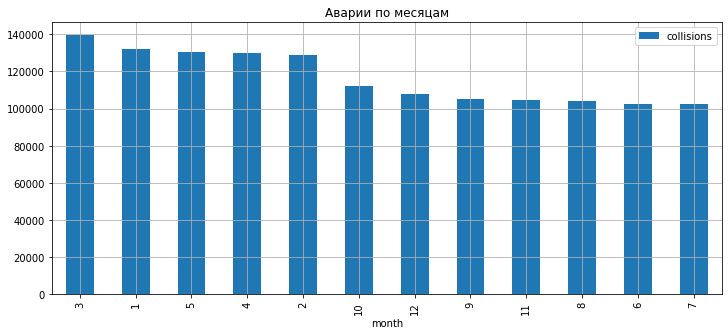

In [63]:
collisions.plot(kind='bar', x='month', y='collisions', grid=True, figsize=(12,5), title = 'Аварии по месяцам')
plt.show()

Напрашивающийся по статистике самых аварийных месяцев вывод немного парадоксален: существенно больше аварий происходит в первой половине года, если быть точнее, в первые пять месяцев года. Это нельзя объяснить ни сезоном отпусков, ни праздниками, ни сезонностью (потому что начало зимы не попадает в статистику), хотя небольшой перекос в сторону зимы всё-таки есть. Возможно, данная статистика связана с переменчивостью погоды зимой и ранней весной, а также ослаблением уровня водительской бдительности с наступлением настоящей весны, когда зимние предосторожности можно отбросить. 

### 2. Задачи для коллег

2.1. Проведите анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП не в дневное время.

In [54]:
query = '''
SELECT c.road_surface AS road_surface_condition,
        c.collision_damage,
        COUNT(c.collision_damage) AS number
FROM collisions c JOIN parties p ON c.case_id = p.case_id
WHERE c.lighting != 'daylight' AND p.party_type = 'car'
GROUP BY c.collision_damage, c.road_surface
ORDER BY c.road_surface DESC;
'''

night_collisions = pd.read_sql_query(query, con=engine) 
night_collisions

road_surface_condition collision_damage  number
0                    None            fatal      25
1                    None    middle damage     359
2                    None          scratch     999
3                    None    severe damage      59
4                    None     small damage    2486
5                     wet            fatal     757
6                     wet    middle damage    8361
7                     wet          scratch   21780
8                     wet    severe damage    1995
9                     wet     small damage   55034
10                  snowy            fatal      32
11                  snowy    middle damage     354
12                  snowy          scratch     602
13                  snowy    severe damage      87
14                  snowy     small damage    2329
15               slippery            fatal       9
16               slippery    middle damage      78
17               slippery          scratch     150
18               slippery    severe damage      21
19               slippery     small damage     393
20                    dry            fatal    7348
21                    dry    middle damage   68539
22                    dry          scratch  148161
23                    dry    severe damage   16377
24                    dry     small damage  367755

In [55]:
night_collisions = night_collisions.dropna()
night_collisions

road_surface_condition collision_damage  number
5                     wet            fatal     757
6                     wet    middle damage    8361
7                     wet          scratch   21780
8                     wet    severe damage    1995
9                     wet     small damage   55034
10                  snowy            fatal      32
11                  snowy    middle damage     354
12                  snowy          scratch     602
13                  snowy    severe damage      87
14                  snowy     small damage    2329
15               slippery            fatal       9
16               slippery    middle damage      78
17               slippery          scratch     150
18               slippery    severe damage      21
19               slippery     small damage     393
20                    dry            fatal    7348
21                    dry    middle damage   68539
22                    dry          scratch  148161
23                    dry    severe damage   16377
24                    dry     small damage  367755

In [56]:
night_collisions['damage_and_road_cond'] = night_collisions['collision_damage'] + ' / ' + night_collisions['road_surface_condition'] 

/tmp/ipykernel_76/3314154133.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  night_collisions['damage_and_road_cond'] = night_collisions['collision_damage'] + ' / ' + night_collisions['road_surface_condition']


In [57]:
night_collisions

road_surface_condition collision_damage  number      damage_and_road_cond
5                     wet            fatal     757               fatal / wet
6                     wet    middle damage    8361       middle damage / wet
7                     wet          scratch   21780             scratch / wet
8                     wet    severe damage    1995       severe damage / wet
9                     wet     small damage   55034        small damage / wet
10                  snowy            fatal      32             fatal / snowy
11                  snowy    middle damage     354     middle damage / snowy
12                  snowy          scratch     602           scratch / snowy
13                  snowy    severe damage      87     severe damage / snowy
14                  snowy     small damage    2329      small damage / snowy
15               slippery            fatal       9          fatal / slippery
16               slippery    middle damage      78  middle damage / slippery
17               slippery          scratch     150        scratch / slippery
18               slippery    severe damage      21  severe damage / slippery
19               slippery     small damage     393   small damage / slippery
20                    dry            fatal    7348               fatal / dry
21                    dry    middle damage   68539       middle damage / dry
22                    dry          scratch  148161             scratch / dry
23                    dry    severe damage   16377       severe damage / dry
24                    dry     small damage  367755        small damage / dry

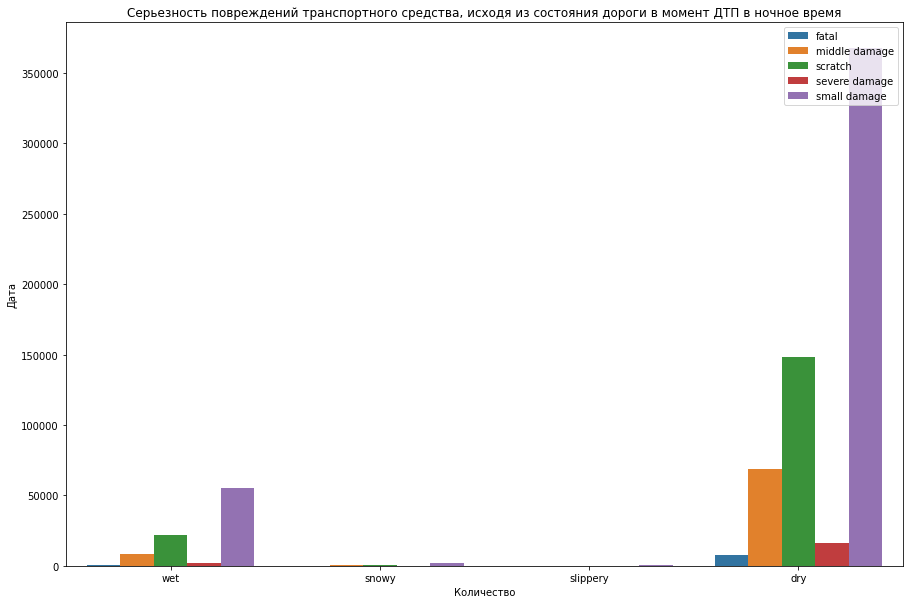

In [58]:
f, ax = plt.subplots(figsize=(15, 10))


sns.barplot(data=night_collisions, 
            x='road_surface_condition',
            y = 'number',
            hue  = 'collision_damage')

ax.legend(ncol=1, loc="upper right", frameon=True)
ax.set(xlabel="Количество",
       ylabel="Дата")

plt.title("Серьезность повреждений транспортного средства, исходя из состояния дороги в момент ДТП в ночное время")
plt.show()

Вывод: в недневное время аварии чаще всего происходят на сухих дорогах, реже - на мокрых, остальные случаи статистически незначимы. Доля более серьезных повреждений, чем просто царапины, выше тоже на сухих дорогах, что контринтуитивно, но может объясняться более высокой аккуратностью водителей на несухих дорогах в условиях плохой видимости. 

Напротив, на сухих дорогах водители, вероятно, позволяют себе полихачить, так как механизмы осторожности, связанные с состоянием дорожного покрытия, ослабевают. Наверное, надо учитывать и статистический фактор: наш датасет, судя по географическим данным, - по Калифорнии, где теплый климат и, как следствие, дороги сухие гораздо чаще и дольше, чем сырые и, тем более, заснеженные. 

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера v2:</b>

<b>✅«Отлично»:</b> Полностью с тобой согласен

2.2. Найдите самые частые причины ДТП для водителей, не виновных в ДТП, но находившихся в состоянии алкогольного опьянения, которое оказывало на них влияние.

In [59]:
query = '''
SELECT c.pcf_violation_category, 
        COUNT(c.pcf_violation_category) AS causes
FROM collisions c JOIN parties p ON c.case_id = p.case_id
WHERE p.party_sobriety = 'had been drinking, under influence' AND p.at_fault = '0'
GROUP BY c.pcf_violation_category
ORDER BY causes DESC;
'''

causes = pd.read_sql_query(query, con=engine) 
causes

pcf_violation_category  causes
0                                 dui    2380
1                            speeding     915
2             automobile right of way     611
3                    improper turning     391
4                  unsafe lane change     303
5                             unknown     302
6           traffic signals and signs     238
7             pedestrian right of way     216
8                pedestrian violation     212
9   other than driver (or pedestrian)     170
10         unsafe starting or backing     117
11                 wrong side of road     104
12              following too closely      47
13          other hazardous violation      42
14             other improper driving      39
15                   improper passing      28
16                   impeding traffic       3
17                  hazardous parking       2
18                             lights       1
19                             brakes       1
20                               None       0

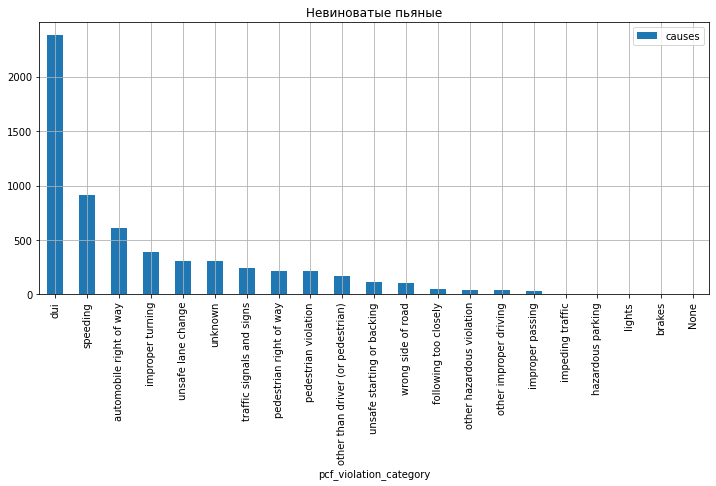

In [62]:
causes.plot(kind='bar', y='causes', x='pcf_violation_category', grid=True, figsize=(12,5), title = 'Невиноватые пьяные')
plt.show()

График показывает, что пьяные водители, не ставшие причиной ДТП, чаще всего попадают в аварии, причинами которых являются:
- пьянство другого водителя, т.е. одно пьянство притягивает другое
- превышение скорости
- несоблюдение приоритета автомобиля

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b>

<b>✅«Отлично»:</b> Интересная заача и верное решение
</div>

2.3. Проанализируйте, в какую погоду чаще всего попадают в аварии машины с разными типами кузова.

2.4. Влияет ли использование телефона в салоне на частоту аварий в автомобилях с МКПП / АКПП?

2.5. За какие аварии выше страховые премии: на трассах или на перекрестках? 

2.6. Причиной скольких аварий стали усталые пешеходы в сумерках на скользких дорогах?

## Создайте модель для оценки водительского риска

Соберем все нужные данные в один датафрейм.

Какие колонки выбрасываю:
- c.county_city_location : номера неинформативны
- c.control_device : вообще не понял, что это, описание данных с графами типа Obscured не способствует пониманию
- c.collision_time : более информативно освещение (c.lighting)
- v.vehicle_type, v.vehicle_transmission : признаков и так очень много, и те, которые имеют отношение к людям и их состоянию, важнее, чем те, которые характеризуют только машину. Оставляем v.vehicle_age, так как это прописано заказчиком. Хотя посмотреть степень влияния типа кузова или трансмиссии на аварийность было бы тоже любопытно. Однако заказчика больше интересуют географические данные.

Какие колонки оставляю, потому что данные в них могут влиять на вероятность ДТП:
- c.county_location : географические данные места ДТП
- c.distance : расстояние до главной дороги важно, так как заказчик намерен создать функцию расчета безопасности маршрута с рекомендациями по нему, а на главных дорогах больше трафик и, как следствие, вероятность ДТП
- c.direction : аналогично, географические данные, важные для расчета маршрута

Однако, анализ с помощью ProfileReport выявил, что многие столбцы очень сильно коррелируют, и информация в них действительно словно дублируется. Так, выявлены следующие закономерности:
- высокая корреляция столбцов location_type & intersection, в первом из которых один из типов ответов это как раз Intersection. Однако в нем менее 25000 записей, тогда как в столбце intersection пропусков почти нет, поэтому удаляем столбец location_type

- также фактически дублируется информация в столбцах motor_vehicle_involved_with & party_type (в большинстве случаев это другие автомобили). Уберем первый из них;

- аналогично и логично коррелируют weather_1 & road_surface. Причем дорога может оставаться мокрой после прошедшего ранее дождя, поэтому оставим второй столбец.

- сильная корреляция между primary_collision_factor & pcf_violation_category. В первом столбце свыше 99,6% данных это vehicle code violation, поэтому можно смело оставить второй столбец, который как раз разъясняет тип нарушения.

- уберем также колонку party_drug_physical, потому что в ней 94% пропусков, а большинство значений - G (= неизвестно), при этом она сильно коррелирует с party_sobriety.

Наблюдается корреляция и у insurance_premium & vehicle_age, но машины одного возраста могут иметь кардинально разную стоимость и, как следствие, разные страховые премии, поэтому оставим обе колонки.


In [67]:
query = '''
WITH cc AS (
    SELECT p.case_id
    FROM parties p JOIN collisions c on c.case_id = p.case_id
    WHERE (p.at_fault = '1' AND p.party_type = 'car')
        AND EXTRACT(YEAR FROM c.collision_date::date) = '2012' 
        AND c.collision_damage != 'scratch')
SELECT cc.case_id,
        c.county_location,
        c.distance,
        c.direction,
        c.intersection,
        c.weather_1,
        c.location_type,
        c.collision_damage,
        c.party_count,
        c.primary_collision_factor,
        c.pcf_violation_category,
        c.type_of_collision,
        c.motor_vehicle_involved_with,
        c.road_surface,
        c.road_condition_1,
        c.lighting,
        c.collision_date,
        c.collision_time,
        p.id AS party_id,
        p.party_number,
        p.party_type,
        p.at_fault,
        p.party_sobriety,
        p.party_drug_physical,
        p.cellphone_in_use,
        p.insurance_premium,
        v.id AS vehicle_id,
        v.vehicle_age
FROM collisions c RIGHT OUTER JOIN cc on cc.case_id = c.case_id 
    JOIN parties p ON cc.case_id = p.case_id 
    JOIN vehicles v on p.case_id = v.case_id AND p.party_number = v.party_number
'''

df = pd.read_sql_query(query, con=engine) 
df 

case_id county_location  distance direction  intersection weather_1  \
0      5403029     santa clara       0.0      None           1.0       fog   
1      5403030     los angeles      72.0      west           0.0     clear   
2      5403031            kern     550.0      east           0.0     clear   
3      5403035            kern       0.0      None           1.0     clear   
4      5403035            kern       0.0      None           1.0     clear   
...        ...             ...       ...       ...           ...       ...   
55611  5667211    contra costa       0.0      None           1.0    cloudy   
55612  5667228     los angeles       0.0      None           1.0     clear   
55613  5667261    contra costa       7.0      west           0.0     clear   
55614  5504723          orange      40.0     south           0.0       fog   
55615  5577446     los angeles       0.0      None           1.0     clear   

      location_type collision_damage  party_count primary_collision_factor  \
0              None            fatal            3   vehicle code violation   
1              None            fatal            3   other improper driving   
2           highway            fatal            1   vehicle code violation   
3              None            fatal            2   vehicle code violation   
4              None            fatal            2   vehicle code violation   
...             ...              ...          ...                      ...   
55611          None    middle damage            2   vehicle code violation   
55612          None    middle damage            2   vehicle code violation   
55613          None    middle damage            2   vehicle code violation   
55614          None    middle damage            2   vehicle code violation   
55615          None    middle damage            2   vehicle code violation   

       ... party_id party_number  party_type at_fault  \
0      ...  2312509            1         car        1   
1      ...  2312512            1         car        1   
2      ...  2312515            1         car        1   
3      ...  2312521            2         car        0   
4      ...  2312520            1         car        1   
...    ...      ...          ...         ...      ...   
55611  ...  2750261            2  road signs        0   
55612  ...  2750293            2  road signs        0   
55613  ...  2750353            2  road signs        0   
55614  ...  2499511            2  road signs        0   
55615  ...  2617129            2  road signs        0   

                              party_sobriety party_drug_physical  \
0                         impairment unknown                   G   
1                      had not been drinking     sleepy/fatigued   
2         had been drinking, under influence                None   
3                      had not been drinking                None   
4                      had not been drinking                None   
...                                      ...                 ...   
55611                                   None                None   
55612                     impairment unknown                   G   
55613                  had not been drinking                None   
55614  had been drinking, impairment unknown                None   
55615                  had not been drinking                None   

      cellphone_in_use insurance_premium  vehicle_id  vehicle_age  
0                  NaN              25.0     1274766          4.0  
1                  0.0              52.0     1274767          7.0  
2                  0.0              21.0     1274768          3.0  
3                  0.0              59.0     1274774          7.0  
4                  0.0              20.0     1274773          3.0  
...                ...               ...         ...          ...  
55611              NaN              12.0     1516434          1.0  
55612              0.0              35.0     1516457          5.0  
55613              

Выбросим многочисленные колонки с разными id, которые были нужны для проверки корректности выгрузки данных из БД.

In [68]:
df = df.drop(['case_id', 'vehicle_id', 'party_id', 'party_number', 'location_type', 'motor_vehicle_involved_with', 'weather_1', 'primary_collision_factor', 'party_drug_physical'], axis=1)

In [69]:
df['collision_date'] = pd.to_datetime(df['collision_date'], format='%Y-%m-%d').dt.month
# оставим только месяц ДТП, год нам известен, а число не принципиально

In [70]:
df['collision_time'] = pd.to_datetime(df['collision_time'], format='%H:%M:%S').dt.hour
# оставим только час ДТП

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55616 entries, 0 to 55615
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   county_location         55616 non-null  object 
 1   distance                55616 non-null  float64
 2   direction               42481 non-null  object 
 3   intersection            55437 non-null  float64
 4   collision_damage        55616 non-null  object 
 5   party_count             55616 non-null  int64  
 6   pcf_violation_category  54986 non-null  object 
 7   type_of_collision       55340 non-null  object 
 8   road_surface            55279 non-null  object 
 9   road_condition_1        55380 non-null  object 
 10  lighting                55474 non-null  object 
 11  collision_date          55616 non-null  int64  
 12  collision_time          55524 non-null  float64
 13  party_type              55589 non-null  object 
 14  at_fault                55616 non-null

In [72]:
profile = ProfileReport(df)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Перейдем к обработке пропусков.
В столбце direction удалить их не можем, их около 20%. Заполним словом unknown.
Подобные значения есть и в столбцах party_sobriety & pcf_violation_category, заполним аналогично

In [73]:
df['direction'].value_counts()
df['direction'] = df['direction'].fillna('unknown')
df['party_sobriety'] = df['party_sobriety'].fillna('impairment unknown')
df['pcf_violation_category'] = df['pcf_violation_category'].fillna('unknown')
df['type_of_collision'] = df['type_of_collision'].fillna('other')
df['road_condition_1'] = df['road_condition_1'].fillna('other')
df['party_type'] = df['party_type'].fillna('other')

В столбцах intersection, cellphone_in_use будем считать для пропусков значением по умолчанию 0: если оно оказалось не заполненным, то значит это не перекресток, а машина не оборудована устройством громкой связи.

In [74]:
df['intersection'] = df['intersection'].fillna(0)
df['cellphone_in_use'] = df['cellphone_in_use'].fillna(0)

В столбцах insurance_premium & vehicle_age заполним медианой.

In [75]:
df['vehicle_age'] = df['vehicle_age'].fillna(df['vehicle_age'].median())
df['insurance_premium'] = df['insurance_premium'].fillna(df['insurance_premium'].median())

В столбцах road_surface, lighting,collision_time количество пропусков незначительное, чем их адекватно заполнить не представляется возможным установить. Удалим пропуски. Всего удалено 1% от датасета, что допустимо.

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b>

<b>✅«Отлично»:</b> Хорошая работа с пропусками


In [76]:
df = df.dropna(subset=['road_surface','lighting','collision_time'])

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55095 entries, 0 to 55615
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   county_location         55095 non-null  object 
 1   distance                55095 non-null  float64
 2   direction               55095 non-null  object 
 3   intersection            55095 non-null  float64
 4   collision_damage        55095 non-null  object 
 5   party_count             55095 non-null  int64  
 6   pcf_violation_category  55095 non-null  object 
 7   type_of_collision       55095 non-null  object 
 8   road_surface            55095 non-null  object 
 9   road_condition_1        55095 non-null  object 
 10  lighting                55095 non-null  object 
 11  collision_date          55095 non-null  int64  
 12  collision_time          55095 non-null  float64
 13  party_type              55095 non-null  object 
 14  at_fault                55095 non-null

А теперь обработка аномальных значений и выбросов.

Колонка direction - OK.

Distance от главной дороги (в метрах, согласно описанию). Нули - это норма, значит, ДТП имело место на главной дороге. Минимальные значения, особенно дробные до 2 метров, вызывают сомнения, но могут обозначать ДТП неподалеку от перекрестков с главными дорогами. И их не так много. А вот значения выше 95го перцентиля превышают 3168 метров, что выглядит более странно, и достигают 1584000, т.е. полутора тысяч километров. Что с ними делать - непонятно. Возможно, они обозначают ДТП, происшедшие на междугородних трассах, а не в городах. Предположим, что мы рассматриваем городские ДТП, поэтому удалим записи, где ДТП произошло в 12 километрах и далее от главной дороги, так все выбросы точно будут удалены.

In [78]:
df.query('distance > 12000')
df = df.query('distance < 12000').reset_index(drop=True)

Insurance premium. График в ProfileReport выглядит довольно адекватно, преобладают невысокие значения, что коррелирует с действительностью, в которой машин бюджет-класса больше, чем премиальных моделей, у которых и страховые выплаты выше. Однако среди значений есть нули. Поскольку таких строк всего 7, скорее всего, это аномалии и их можно безболезненно удалить.

In [79]:
df.query('insurance_premium == 0')
df = df.query('insurance_premium != 0').reset_index(drop=True)

Vehicle_age. 5,4% значений - нули. Если они обозначают новые машины, то без проблем. Но было замечено, что есть некоторое количество строк, где 0 в возрасте автомобиля сочетается с очень низкой страховой премией, что маловероятно для новых машин. Если взять 5й перцентиль по размеру премии (18 тысяч долларов), то таких автомобилей 80. Поскольку заказчик особенно внимательно просил рассмотреть признак возраста автмобиля, удалим эти сомнительные строки. 
Также отрежем автомобили возрастом 10 лет и старше, так как в каршеринговым сервисах такие машины, как правило, не используются.

In [80]:
df.query('vehicle_age == 0 and insurance_premium < 18')

df = df.loc[(df['vehicle_age'] != 0) | (df['insurance_premium'] >= 18.0)].reset_index(drop=True)
df.query('vehicle_age == 0')
df = df.query('vehicle_age < 10') # один выброс в 191 год + отрезаем старые автомобили

In [81]:
df.duplicated().sum() # удалим 77 дубликат
df = df.drop_duplicates().reset_index(drop=True)

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49485 entries, 0 to 49484
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   county_location         49485 non-null  object 
 1   distance                49485 non-null  float64
 2   direction               49485 non-null  object 
 3   intersection            49485 non-null  float64
 4   collision_damage        49485 non-null  object 
 5   party_count             49485 non-null  int64  
 6   pcf_violation_category  49485 non-null  object 
 7   type_of_collision       49485 non-null  object 
 8   road_surface            49485 non-null  object 
 9   road_condition_1        49485 non-null  object 
 10  lighting                49485 non-null  object 
 11  collision_date          49485 non-null  int64  
 12  collision_time          49485 non-null  float64
 13  party_type              49485 non-null  object 
 14  at_fault                49485 non-null

Некоторые столбцы (как 'cellphone_in_use') содержат категориальные переменные, но имеет числовые типы данных. Поэтому категоризируем их:

In [83]:
df['cellphone_in_use'] = df['cellphone_in_use'].astype('category')
df['intersection'] = df['intersection'].astype('category')
df['party_count'] = df['party_count'].astype('category')

Предобработка завершена. Некорректных значений было порядка 2%, но общие "потери" составили 16,5% за счет сокращения выборки автомобилей по их возрасту. Переходим к созданию модели.

In [84]:
# выделим целевую переменную

X = df.drop('at_fault', axis=1)
y = df['at_fault']

In [85]:
# разделим данные на три выборки

X_train, x_2, y_train, y_2 = train_test_split(
    X, y, test_size=0.4, random_state=76767, shuffle=True)
X_valid, X_test, y_valid, y_test = train_test_split(
    x_2, y_2, test_size=0.5, random_state=7676, shuffle=True)

In [86]:
print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер валидационной выборки: {X_valid.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (29691, 18)
Размер валидационной выборки: (9897, 18)
Размер тестовой выборки: (9897, 18)


In [87]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29691 entries, 6156 to 7120
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   county_location         29691 non-null  object  
 1   distance                29691 non-null  float64 
 2   direction               29691 non-null  object  
 3   intersection            29691 non-null  category
 4   collision_damage        29691 non-null  object  
 5   party_count             29691 non-null  category
 6   pcf_violation_category  29691 non-null  object  
 7   type_of_collision       29691 non-null  object  
 8   road_surface            29691 non-null  object  
 9   road_condition_1        29691 non-null  object  
 10  lighting                29691 non-null  object  
 11  collision_date          29691 non-null  int64   
 12  collision_time          29691 non-null  float64 
 13  party_type              29691 non-null  object  
 14  party_sobriety      

In [88]:
# категоризация и скалирование

num = ['distance','vehicle_age', 'insurance_premium', 'collision_time', 'collision_date']

cat = ['county_location',
       'direction',
       'intersection',
       'collision_damage',
       'party_count',
       'pcf_violation_category',
       'type_of_collision',
       'road_surface',
       'road_condition_1',
       'lighting',
       'party_type',
       'party_sobriety',
       'cellphone_in_use'
      ]    


col_transformer = ColumnTransformer(
                    transformers=[
                        ('ss', StandardScaler(), num),
                        ('ohe', OneHotEncoder(drop='first', sparse=False), cat)
                    ],
                    remainder='drop',
                    n_jobs=-1
                    )

In [89]:
X_train = col_transformer.fit_transform(X_train)
X_valid = col_transformer.transform(X_valid)  
X_test = col_transformer.transform(X_test)

## Поиск лучшей модели

Прежде, чем начать обучение моделей, определимся с метрикой оценки качества. В проекте решается задача бинарной классификации.

По идее заказчика система должна работать таким образом, что при высоком уровне риска попадания в ДТП водитель должен увидеть предупреждение и рекомендации по маршруту. В этом случае ошибка типа False Positive, когда "невиновный" водитель получает предупреждение, конечно, не несет реальной угрозы, но может вызвать непонимание и негативные впечатления у клиентов о сервисе. В конечном итоге это может привести к тому, что при большом количестве предупреждений водители перестанут принимать их во внимание. Поэтому нам важен показатель Precision.

В то же время, если система не предупредит водителя об опасностях маршрута и тот попадет в ДТП, то есть если система  допустит ошибку False Negative, это также делает бессмысленной ее работу. Кроме того, такого рода ошибки несут реальную угрозу жизни и здоровью клиентов, имуществу компании. Поэтому модель должна минимзировать количество ложно отрицательных ответов. То есть показатель Recall не менее важен.

Для сочетания в одной метрике показателей Precision и Recall выберем для оценки моделей F1-меру, которая их оба объединяет.

## Модель 1.  Логистическая регрессия

In [90]:
%%time
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(X_train, y_train)
predictions = model.predict(X_valid)
f1 = f1_score(y_valid, predictions)
print("Значение F1:", f1)

Значение F1: 0.6871912693854106
CPU times: user 414 ms, sys: 26.1 ms, total: 440 ms
Wall time: 405 ms


In [91]:
%%time
estimator = LogisticRegression()

max_iter = range(10, 30)
solver = ['liblinear']
warm_start = [True, False]
C = np.arange(0.3, 1, 0.3)

params = {'max_iter': max_iter, 'warm_start': warm_start, 'solver': solver, 'C': C}

random_estimator = RandomizedSearchCV(estimator=estimator, param_distributions=params, n_iter=20, scoring='f1', n_jobs=-1, verbose=8, random_state=12345, return_train_score=True)
random_estimator.fit(X_train, y_train)
lr_score = random_estimator.best_score_ 
print(random_estimator.best_params_)
print(lr_score)



Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END C=0.3, max_iter=12, solver=liblinear, warm_start=True; total time=   0.2s
[CV 2/5] END C=0.3, max_iter=12, solver=liblinear, warm_start=True; total time=   0.3s
[CV 3/5] END C=0.3, max_iter=12, solver=liblinear, warm_start=True; total time=   0.3s
[CV 4/5] END C=0.3, max_iter=12, solver=liblinear, warm_start=True; total time=   0.3s
[CV 5/5] END C=0.3, max_iter=12, solver=liblinear, warm_start=True; total time=   0.3s
[CV 1/5] END C=0.3, max_iter=19, solver=liblinear, warm_start=False; total time=   0.2s
[CV 2/5] END C=0.3, max_iter=19, solver=liblinear, warm_start=False; total time=   0.3s
[CV 3/5] END C=0.3, max_iter=19, solver=liblinear, warm_start=False; total time=   0.4s
[CV 4/5] END C=0.3, max_iter=19, solver=liblinear, warm_start=False; total time=   0.3s
[CV 5/5] END C=0.3, max_iter=19, solver=liblinear, warm_start=False; total time=   0.3s
[CV 1/5] END C=0.3, max_iter=26, solver=liblinear, warm_start=F

Лучшие параметры для логистической регрессии согласно RandomSearchCV: {'warm_start': True, 'solver': 'liblinear', 'max_iter': 12, 'C': 0.8999999999999999}
На них модель показывает F1 = 0.681, что даже немного хуже базовой модели без перебора ГП. 

Модель тестировалась и на подборе других гиперпараметров, но, в частности, значительно дольше обучалась при solver=newton-cg, поэтому я затем убрал это из подбора ГП, чтобы сократить время обучения при перезапуске тетрадки.

### Модель 2. Случайный лес

In [92]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]

max_depth = [int(x) for x in np.linspace(1, 50, num = 5)]

max_features = ['auto', 'sqrt']

min_samples_split = [2, 5, 10]

min_samples_leaf = [1, 3, 5]

rf_grid = {'n_estimators': n_estimators,
           'max_features': max_features,
           'max_depth': max_depth,
           'min_samples_split': min_samples_split,
           'min_samples_leaf': min_samples_leaf}

rf = RandomizedSearchCV(estimator = RandomForestClassifier(random_state=12345), 
                   param_distributions = rf_grid, 
                   cv = 5, n_iter = 10,
                    scoring='f1', n_jobs=-1, verbose=8, random_state=12345, return_train_score=True)

rf.fit(X_train, y_train)
rf_score = rf.best_score_
print(rf.best_params_)
print(rf_score)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END max_depth=13, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=90; total time=   1.8s
[CV 2/5] END max_depth=13, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=90; total time=   1.8s
[CV 3/5] END max_depth=13, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=90; total time=   1.8s
[CV 4/5] END max_depth=13, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=90; total time=   1.8s
[CV 5/5] END max_depth=13, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=90; total time=   1.8s
[CV 1/5] END max_depth=1, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV 2/5] END max_depth=1, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV 3/5] END max_depth=1, max_features=sqrt, min_samples_leaf=3, min_samples_s

<div class="alert alert-warning" role="alert">
<b>Комментарий ревьюера:</b>

<b>⚠️«Можно лучше»: </b> Get_dummies и OHE не желательны для моделей на основе дерева. Они сильно замедляют работу данных моделей.

Для подбора кодировщика можешь пользоваться данной <a href="https://www.kaggle.com/getting-started/159882"> схемой </a>.


</div>

Случайный лес с задачей справляется получше: при гиперпараметрах {'n_estimators': 90, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 25} показывает результат F1 = 0.701

### Модель 3. Catboost (градиентный бустинг)

In [93]:
target_cat = df['at_fault']
features_cat = df.drop('at_fault', axis=1)

In [94]:
target_cat.dtype
features_cat['distance'] = features_cat['distance'].astype('int')
features_cat['collision_time'] = features_cat['collision_time'].astype('int')
features_cat['insurance_premium'] = features_cat['insurance_premium'].astype('int')
features_cat['vehicle_age'] = features_cat['vehicle_age'].astype('int')

features_cat.dtypes

county_location             object
distance                     int64
direction                   object
intersection              category
collision_damage            object
party_count               category
pcf_violation_category      object
type_of_collision           object
road_surface                object
road_condition_1            object
lighting                    object
collision_date               int64
collision_time               int64
party_type                  object
party_sobriety              object
cellphone_in_use          category
insurance_premium            int64
vehicle_age                  int64
dtype: object

In [95]:
features_cat['intersection'].unique()
features_cat['intersection'] = features_cat['intersection'].replace('0.0', '0')
features_cat['intersection'] = features_cat['intersection'].replace('1.0', '1')
features_cat['intersection'] = features_cat['intersection'].astype('str')
features_cat['cellphone_in_use'] = features_cat['cellphone_in_use'].astype('str')

In [96]:
features_train_cat, features_test_cat, target_train_cat, target_test_cat = train_test_split(
    features_cat, 
    target_cat, 
    test_size=0.4, 
    random_state=7676
)

In [97]:
# cat_features = [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15]

cat_features = list(features_train_cat.select_dtypes(['category', 'object']).columns)
# cat_features

In [98]:
%%time

cat_data = Pool(data=features_train_cat,
          label=target_train_cat,
          cat_features=cat_features,
          )

iterations = 1000
eval_metric = 'F1'
#random_seed = [int(x) for x in np.linspace(1, 100, num = 5)]
learning_rate = 0.03
verbose = True

cat_params = {'iterations': iterations,
             'eval_metric': eval_metric,
             'learning_rate': learning_rate,
             'verbose': verbose}

catboost_model = CatBoostClassifier(**cat_params)
# catboost_model.fit(features_train_cat, target_train_cat, cat_features=cat_features)

grid = {'learning_rate': [0.03, 0.1],
        'depth': [6, 10],
        'l2_leaf_reg': [7, 9]}

grid_search_result = catboost_model.grid_search(grid, X=cat_data, verbose=5, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6772322	test: 0.6849524	best: 0.6849524 (0)	total: 132ms	remaining: 2m 12s
1:	learn: 0.6772322	test: 0.6849524	best: 0.6849524 (0)	total: 192ms	remaining: 1m 35s
2:	learn: 0.6706527	test: 0.6811650	best: 0.6849524 (0)	total: 249ms	remaining: 1m 22s
3:	learn: 0.6786667	test: 0.6842806	best: 0.6849524 (0)	total: 296ms	remaining: 1m 13s
4:	learn: 0.6766218	test: 0.6831134	best: 0.6849524 (0)	total: 352ms	remaining: 1m 10s
5:	learn: 0.6761269	test: 0.6808920	best: 0.6849524 (0)	total: 414ms	remaining: 1m 8s
6:	learn: 0.6747429	test: 0.6813272	best: 0.6849524 (0)	total: 481ms	remaining: 1m 8s
7:	learn: 0.6762809	test: 0.6810395	best: 0.6849524 (0)	total: 539ms	remaining: 1m 6s
8:	learn: 0.6725259	test: 0.6799690	best: 0.6849524 (0)	total: 600ms	remaining: 1m 6s
9:	learn: 0.6716522	test: 0.6780982	best: 0.6849524 (0)	total: 647ms	remaining: 1m 4s
10:	learn: 0.6705653	test: 0.6782439	best: 0.6849524 (0)	total: 695ms	remaining: 1m 2s
11:	learn: 0.6694049	test: 0.6768269	best: 0.684

In [100]:
catboost_params = catboost_model.get_params()
catboost_score = catboost_model.get_best_score()
print(catboost_params)
print(catboost_score)

{'iterations': 1000, 'learning_rate': 0.1, 'verbose': True, 'eval_metric': 'F1', 'depth': 6, 'l2_leaf_reg': 7}
{'learn': {'Logloss': 0.4003417738196854, 'F1': 0.7900361010830325}}


Перебор гиперпараметров Catboost помог выявить следующие лучшие показатели:
F1 = 0.79 на тесте при следующих параметрах модели:
{'iterations': 1000,
 'learning_rate': 0.1,
 'verbose': True,
 'eval_metric': 'F1',
 'depth': 6,
 'l2_leaf_reg': 9}
 
Эта модель показала метрику лучше других.

Подведем итоги выбора модели, сведя все результаты в одну таблицу.

In [102]:

model_data = [['Logistic Regression', lr_score],
             ['RandomForest Classifier', rf_score],
             ['CatBoostClassifier', catboost_score]]
model_comparison = pd.DataFrame(data= model_data, columns = cols)
model_comparison

model                                      best_f1_score
0      Logistic Regression                                           0.687782
1  RandomForest Classifier                                           0.700007
2       CatBoostClassifier  {'learn': {'Logloss': 0.4003417738196854, 'F1'...

Как можно видеть в таблице, лучше всех себя показал Катбуст, хуже всех - логистическая регрессия.


Проведем теперь отдельную проверку лучшей модели в работе.

In [103]:
eval_dataset = Pool(data=features_test_cat,
                    label=target_test_cat,
                    cat_features=cat_features)

In [104]:
cat_predictions = catboost_model.predict(eval_dataset)

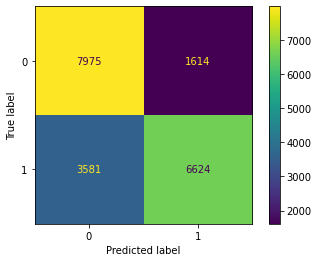

In [105]:
conf_matrix = confusion_matrix(target_test_cat, cat_predictions) # надо передавать cat_predictions
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
display_labels=model.classes_)
disp.plot()

Из confusion matrix видим, что модель дает 6624 ответов типа TP (true positive) и 7975 ответов TN (true negative). Отметим, что количество непредсказанных ДТП (3581) в два с лишним раза превышает количество неверно предсказанных ДТП (1614). Но в целом результаты можно признать удовлетворительными.

## Проведите анализ важности факторов ДТП

In [106]:
importances = pd.DataFrame(catboost_model.feature_importances_,
                         features_cat.columns)
importances

0
county_location          2.610611
distance                 2.455749
direction                1.789038
intersection             0.097479
collision_damage         2.497001
party_count             42.701220
pcf_violation_category   6.052519
type_of_collision        2.939407
road_surface             1.018968
road_condition_1         0.944390
lighting                 1.735067
collision_date           0.706689
collision_time           1.631394
party_type              14.808199
party_sobriety           8.266373
cellphone_in_use         0.118761
insurance_premium        6.921784
vehicle_age              2.705350

In [107]:
feat_imp = px.bar(
    importances,
    x=importances[0],
    )

feat_imp.update_layout(barmode='stack', yaxis={'categoryorder':'total ascending'})
feat_imp.update_xaxes(title_text='Importance')
feat_imp.update_yaxes(title_text='Feature')
feat_imp.update_layout(title_text='Features importance')
feat_imp.update_traces(marker_color='rgb(100, 100, 200)', opacity=0.6)

feat_imp.show()



Неожиданные результаты. Посмотрим, как именно они коррелируют с целевым признаком.

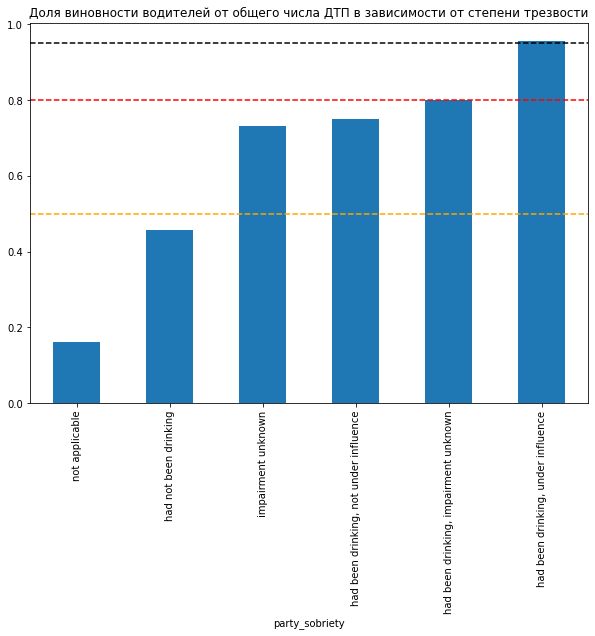

In [109]:
df.groupby('party_sobriety')['at_fault'].mean().sort_values().plot(kind='bar', figsize=(10,7), title='Доля виновности водителей от общего числа ДТП в зависимости от степени трезвости')
plt.axhline(0.5, color = 'orange',linestyle='--')
plt.axhline(0.8, color = 'r',linestyle='--')
plt.axhline(0.95, color = 'black',linestyle='--')
plt.show()

Здесь всё логично: если водитель нетрезв, вероятность, что в ДТП виноват он - от 75% до 95% в зависимости от степени влияния алкоголя на его организм. Если не пил - порядка 45%. 

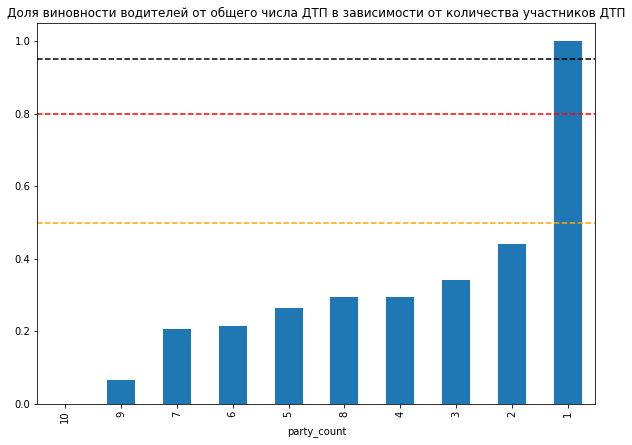

In [111]:
df.groupby('party_count')['at_fault'].mean().sort_values().plot(kind='bar', figsize=(10,7), title='Доля виновности водителей от общего числа ДТП в зависимости от количества участников ДТП')
plt.axhline(0.5, color = 'orange',linestyle='--')
plt.axhline(0.8, color = 'r',linestyle='--')
plt.axhline(0.95, color = 'black',linestyle='--')
plt.show()

Видимо, это надо трактовать как "Если в ДТП 1 участник, то это обязательно водитель" (въехавший не в другое транспортное средство, надо полагать)

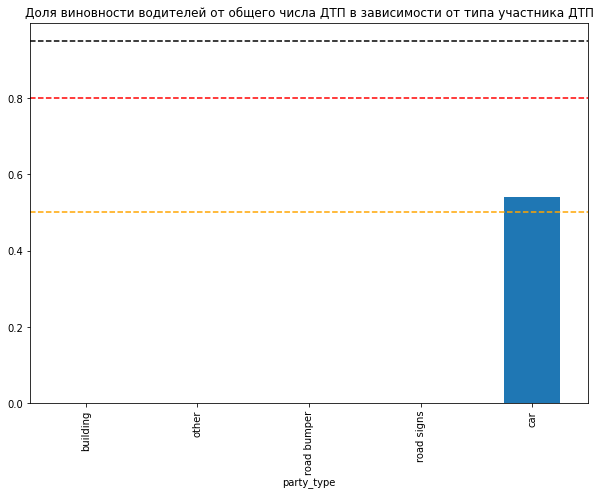

In [112]:
df.groupby('party_type')['at_fault'].mean().sort_values().plot(kind='bar', figsize=(10,7), title='Доля виновности водителей от общего числа ДТП в зависимости от типа участника ДТП')
plt.axhline(0.5, color = 'orange',linestyle='--')
plt.axhline(0.8, color = 'r',linestyle='--')
plt.axhline(0.95, color = 'black',linestyle='--')
plt.show()

Трактовка следующая: Чуть более, чем в половине случаев, в ДТП виноваты автомобили.

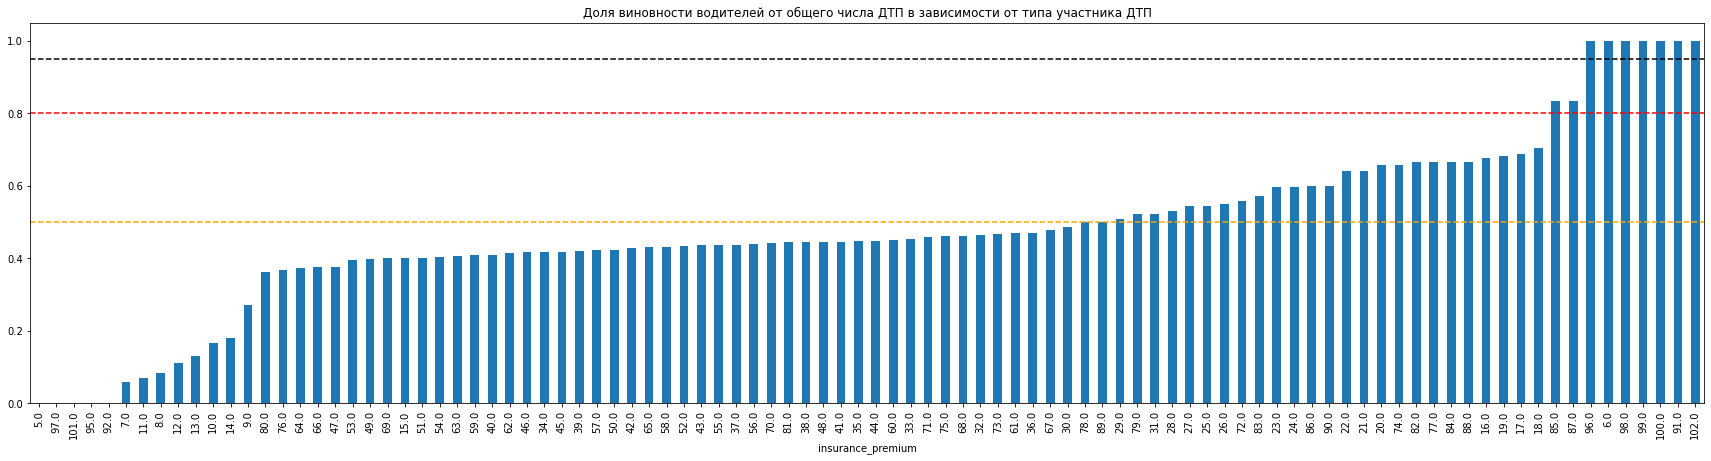

In [114]:
df.groupby('insurance_premium')['at_fault'].mean().sort_values().plot(kind='bar', figsize=(30,7), title='Доля виновности водителей от общего числа ДТП в зависимости от типа участника ДТП')
plt.axhline(0.5, color = 'orange',linestyle='--')
plt.axhline(0.8, color = 'r',linestyle='--')
plt.axhline(0.95, color = 'black',linestyle='--')
plt.show()

Вот это тоже весьма любопытные данные. В правой части графика находятся либо дорогие автомобили (как следствие, с высокой страховой премией), либо бюджетные модели (видим значения 16-19). Причем у самых дорогих вероятность ДТП почти единица. Предположим, что на дорогих моделях любят погонять с превышением скорости и построим еще один график.

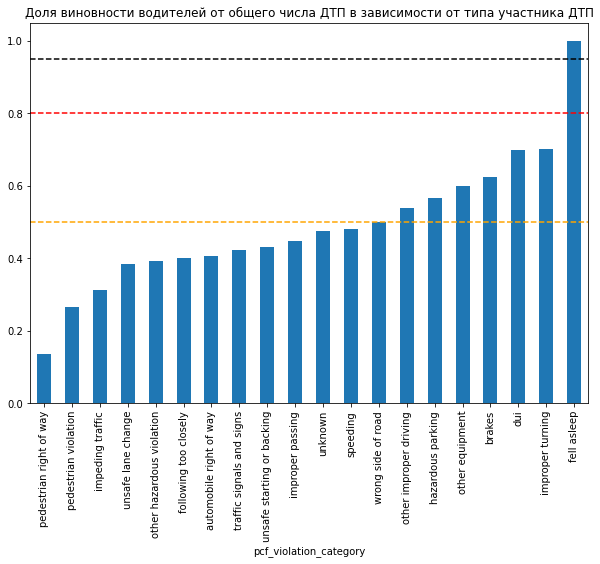

In [115]:
df.groupby('pcf_violation_category')['at_fault'].mean().sort_values().plot(kind='bar', figsize=(10,7), title='Доля виновности водителей от общего числа ДТП в зависимости от типа участника ДТП')
plt.axhline(0.5, color = 'orange',linestyle='--')
plt.axhline(0.8, color = 'r',linestyle='--')
plt.axhline(0.95, color = 'black',linestyle='--')
plt.show()

Заснул за рулем = попал в ДТП (но в исходных данных был лишь один такой случай). Основные факторы - неправильные маневры при поворотах и вождение в состоянии опьянения, а также проблемы с тормозами или другим оборудованием. Гипотеза о превышении скорости не подтвердилась.

## Выводы

Мы обработали довольно объемную базу данных по ДТП, отобрали из нее необходиые данные, в частности, факторы, которые могут влиять на вероятность ДТП, преобразовали их из SQL в Pandas DataFrame, провели предобработку, построили 3 модели машинного обучения, выявили лучшую из них.

Кратко опишите лучшую модель: Catboost с подбором гиперпараметров через grid_search показывает метрику F1 в районе 0.79, то есть предсказывает порядка 79% ДТП.
Гиперпараметры модели: {'iterations': 1000, 'learning_rate': 0.1, 'verbose': True, 'eval_metric': 'F1', 'depth': 6, 'l2_leaf_reg': 9}

После получения предсказаний от модели провели исследование feature importance, проанализировали графики и наши гипотезы по ним.

Сделайте вывод: насколько возможно создание адекватной системы оценки риска при выдаче авто? 

Анализ feature importance показал, что иногда основное влияние на факт ДТП зависит не только от трезвости участника: почти в половине случаев в авариях виноваты не автомобили. Тем не менее, алкогольное опьянение водителя оказывает наибольшее влияние на вероятность ДТП. Поддерживаю идею заказчика оборудовать автомобиль анализатором алкогольного опьянения так, чтобы измерение состояния при посадке сделать обязательным условием допуска за руль.  
Последний график также показывает, что важным фактором является исправное состояние автомобиля в каршеринговом сервисе.
